In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pathlib

import tensorflow as tf
from keras import layers
from keras.models import Sequential
import random
import keras
!pip install scikeras
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
data_dir = "/content/drive/MyDrive/sptech/TCC/fruits_dataset/banana"
data_dir = pathlib.Path(data_dir)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
image_count = len(list(data_dir.glob("**/*.jpg")))
labels = os.listdir(r"{}/train".format(data_dir))
print(image_count)
print(labels)

2979
['rotten', 'unripe', 'overripe', 'ripe', 'raw']


### Vizualizing the toal of images per classes

In [ ]:
train_classes = os.listdir(r"{}/train".format(data_dir))

for label in labels:
  total_train = os.listdir(r"{}/train/{}".format(data_dir, label))
  print("total for {} train: {}".format(label, len(total_train)))

  total_test = os.listdir(r"{}/test/{}".format(data_dir, label))
  print("total for {} test: {}".format(label, len(total_test)))

total for rotten train: 544
total for rotten test: 117
total for unripe train: 449
total for unripe test: 118
total for overripe train: 468
total for overripe test: 119
total for ripe train: 576
total for ripe test: 142
total for raw train: 380
total for raw test: 66


### Visualizing one image per class

IndexError: ignored

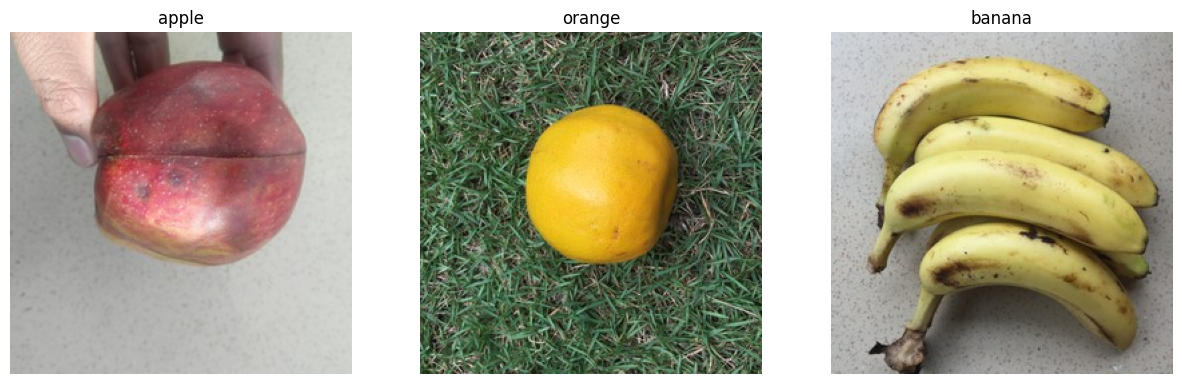

In [ ]:
ax, sub = plt.subplots(1, len(labels), figsize=(15, 15))

for i in range(0, 5):
  sub[i].set_title(labels[i])
  sub[i].axis("off")
  img = str(list(data_dir.glob(r"train/{}/*.jpg".format(labels[i])))[10])
  sub[i].imshow(cv.cvtColor(cv.imread(img), cv.COLOR_BGR2RGB))

## Dividing the dataset

In [ ]:
# Creating test dataset
# Jump this if the folder is already created
# for label in labels:
#   images = os.listdir(r"{}/train/{}".format(data_dir, label))
#   total_test_images = int(len(images) * 0.2)
#   print("{}: {}".format(label, total_test_images))
#   print("Criando para {}".format(label))

#   for i in range(0, total_test_images):
#     image = random.choice(images)
#     print("Movendo: ", r"{}/train/{}/{}".format(data_dir, label, image))
#     read_image = cv.imread(r"{}/train/{}/{}".format(data_dir, label, image))
#     cv.imwrite(r"{}/test/{}/{}".format(data_dir, label, image), read_image)
#     images.remove(image)
#     os.remove(r"{}/train/{}/{}".format(data_dir, label, image))

rotten: 67
Criando para rotten
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0409.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0250.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0386.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0273.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0368.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0230.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0174.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0254.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0022.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0125.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/fruits_dataset/train/rotten/IMG0186.jpg
Movendo:  /content/drive/MyDrive/sptech/TCC/f

## Preparing training dataset

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
  r"{}/train".format(data_dir),
  validation_split=0.2,
  subset="both",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

Found 2417 files belonging to 5 classes.
Using 1934 files for training.
Using 483 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['overripe', 'raw', 'ripe', 'rotten', 'unripe']


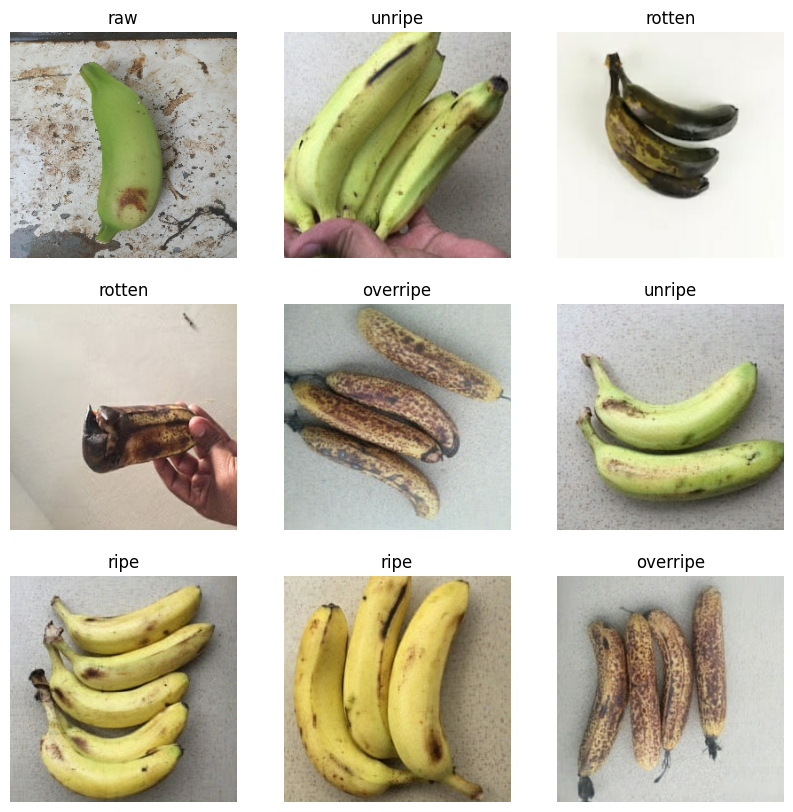

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data augmentation

In [ ]:
num_classes = len(class_names)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, fill_mode="constant"),
    layers.RandomZoom(0.2),
])

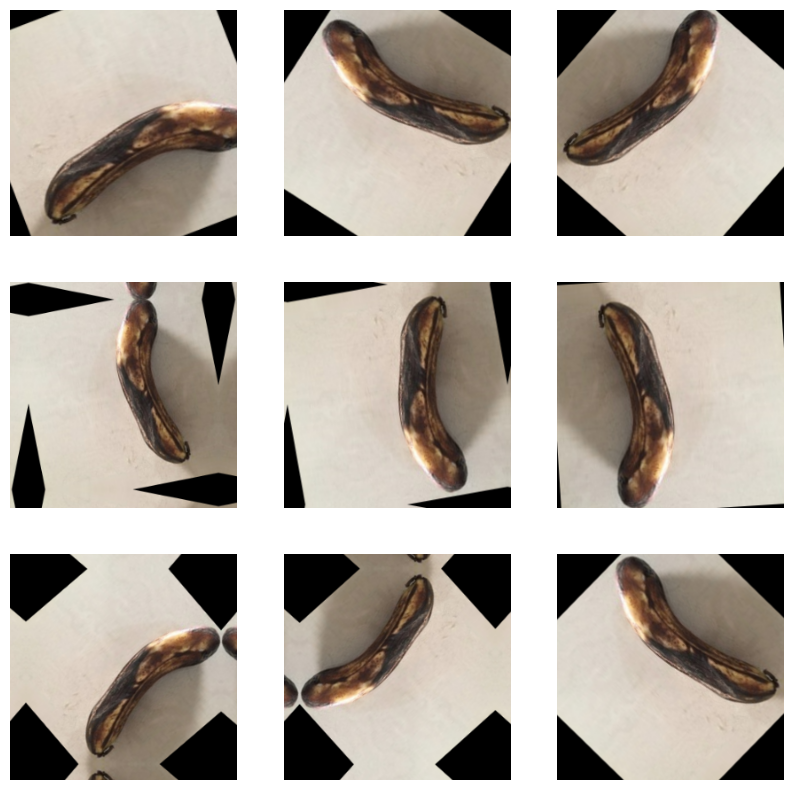

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Model

In [ ]:
def get_model(filters=[32, 64, 128], denses=[256, 64], kernels=[3, 3, 3], dropout=0.5, reg=0.001):
  model = Sequential()
  model.add(data_augmentation)
  # Adding convolutions
  for i, filter in enumerate(filters):
    if i == 0:
      model.add(layers.Conv2D(filter, kernels[i] + 2, padding="same", activation="relu", input_shape=(img_height, img_width, 3)))
      model.add(layers.Conv2D(filter, kernels[i], padding="same", activation="relu"))
    else:
      model.add(layers.Conv2D(filter, kernels[i], padding="same", activation="relu"))
      model.add(layers.Conv2D(filter, kernels[i], padding="same", activation="relu"))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, padding="same", activation="relu"))
  model.add(layers.Conv2D(128, 1, padding="same", activation="relu"))
  model.add(layers.MaxPooling2D())

  model.add(layers.Dropout(dropout))
  model.add(layers.Flatten())

  # Adding denses
  n = 0
  for dense in denses:
    model.add(layers.Dense(dense, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)))
    if n == 0:
      n += 1
      model.add(layers.Dropout(dropout))


  model.add(layers.Dense(num_classes, name="outputs", activation="softmax"))

  return model

In [ ]:
def train_model(model, epochs, monitor):
  return model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
      tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor=monitor,
        verbose=1,
        save_best_only=True
      ),
      keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
    ]
  )

### Grid search

In [ ]:
def read_dataset(dir):
  X = []
  y = []
  for img_class in os.listdir(dir):
      for img in os.listdir(os.path.join(dir, img_class)):
          img_path = os.path.join(dir, img_class, img)
          try:
              img_read = cv.imread(img_path)
              X.append(img_read.flatten())
              y.append(img_class)
          except Exception as e:
              print("issue with image {}".format(img_path))
  return (X, y)

(X_train, y_train) = read_dataset("{}/train".format(data_dir))
(X_test, y_test) = read_dataset("{}/test".format(data_dir))

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
classifier = KerasClassifier(
  get_model,
  batch_size=32,
  denses=[256],
  # filters=[32, 64, 128],
  # kernels=[3, 3, 3],
  # dropout=0.3,
  # reg=0.01
)
classifier.get_params().keys()
validator = GridSearchCV(
  classifier,
  param_grid={
    'denses': [[256], [128], [64, 64], [64, 32]],
    # 'filters': [[32, 64, 128], [64, 64, 128], [64, 128, 256], [128, 256, 256]],
    # 'kernels': [[3, 3, 3], [5, 3, 3], [7, 5, 3]],
    # 'dropout': [0.3, 0.4, 0.5],
    # 'reg': [0.01, 0.001, 0.0001],
    # 'epochs': [15, 20, 30]
  },
  scoring='neg_log_loss',
  n_jobs=1
)
validator.fit(X_train, y_train)

ValueError: ignored

### Saving the model with lower loss

In [ ]:
loss_model = get_model()
loss_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"],
)
filepath = "/content/drive/MyDrive/sptech/TCC/models/bananas_model_v2.hdf5"
epochs = 50
loss_history = train_model(loss_model, epochs, "val_accuracy")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


61/61 [==============================] - ETA: 0s - loss: 2.8764 - accuracy: 0.3676
Epoch 1: val_accuracy improved from -inf to 0.23188, saving model to /content/drive/MyDrive/sptech/TCC/models/bananas_model_v2.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 693s 10s/step - loss: 2.8764 - accuracy: 0.3676 - val_loss: 4.3595 - val_accuracy: 0.2319
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.5962 - accuracy: 0.6163
Epoch 2: val_accuracy improved from 0.23188 to 0.23395, saving model to /content/drive/MyDrive/sptech/TCC/models/bananas_model_v2.hdf5
61/61 [==============================] - 48s 714ms/step - loss: 1.5962 - accuracy: 0.6163 - val_loss: 2.0682 - val_accuracy: 0.2340
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.8268
Epoch 3: val_accuracy did not improve from 0.23395
61/61 [==============================] - 46s 698ms/step - loss: 1.0337 - accuracy: 0.8268 - val_loss: 2.3778 - val_accuracy: 0.2340
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.8666
Epoch 4: val_accuracy improved from 0.23395 to 0.33333, saving model to /content/drive/MyDrive/sptech/TCC/models/bananas_model_v2.hdf5
61

In [ ]:
loss_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)     

### Saving model with higher accuracy

In [ ]:
acc_model = get_model()
acc_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"],
)

In [ ]:
filepath = "/content/drive/MyDrive/sptech/TCC/models/acc_model.hdf5"
epochs = 60
acc_history = train_model(acc_model, epochs, "val_accuracy")

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


39/40 [============================>.] - ETA: 0s - loss: 1.7645 - accuracy: 0.3526
Epoch 1: val_accuracy improved from -inf to 0.45367, saving model to /content/drive/MyDrive/sptech/TCC/models/acc_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 11s 206ms/step - loss: 1.7627 - accuracy: 0.3530 - val_loss: 1.2082 - val_accuracy: 0.4537
Epoch 2/60
39/40 [============================>.] - ETA: 0s - loss: 1.0082 - accuracy: 0.5537
Epoch 2: val_accuracy improved from 0.45367 to 0.76997, saving model to /content/drive/MyDrive/sptech/TCC/models/acc_model.hdf5
40/40 [==============================] - 7s 160ms/step - loss: 1.0081 - accuracy: 0.5527 - val_loss: 0.7289 - val_accuracy: 0.7700
Epoch 3/60
39/40 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.7131
Epoch 3: val_accuracy did not improve from 0.76997
40/40 [==============================] - 6s 140ms/step - loss: 0.6634 - accuracy: 0.7133 - val_loss: 0.8183 - val_accuracy: 0.6933
Epoch 4/60
39/40 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8037
Epoch 4: val_accuracy improved from 0.76997 to 0.79233, saving model to /content/drive/MyDrive/sptech/TCC/models/acc_model.hdf5
40/40 [==========

## Getting best models

In [ ]:
# best_acc_model = tf.keras.models.load_model("/content/drive/MyDrive/sptech/TCC/models/acc_model.hdf5")
# best_loss_model = tf.keras.models.load_model("/content/drive/MyDrive/TCC/models/loss_model.hdf5")
filepath = "/content/drive/MyDrive/sptech/TCC/models/bananas_model_v2.hdf5"
best_model = tf.keras.models.load_model(filepath)

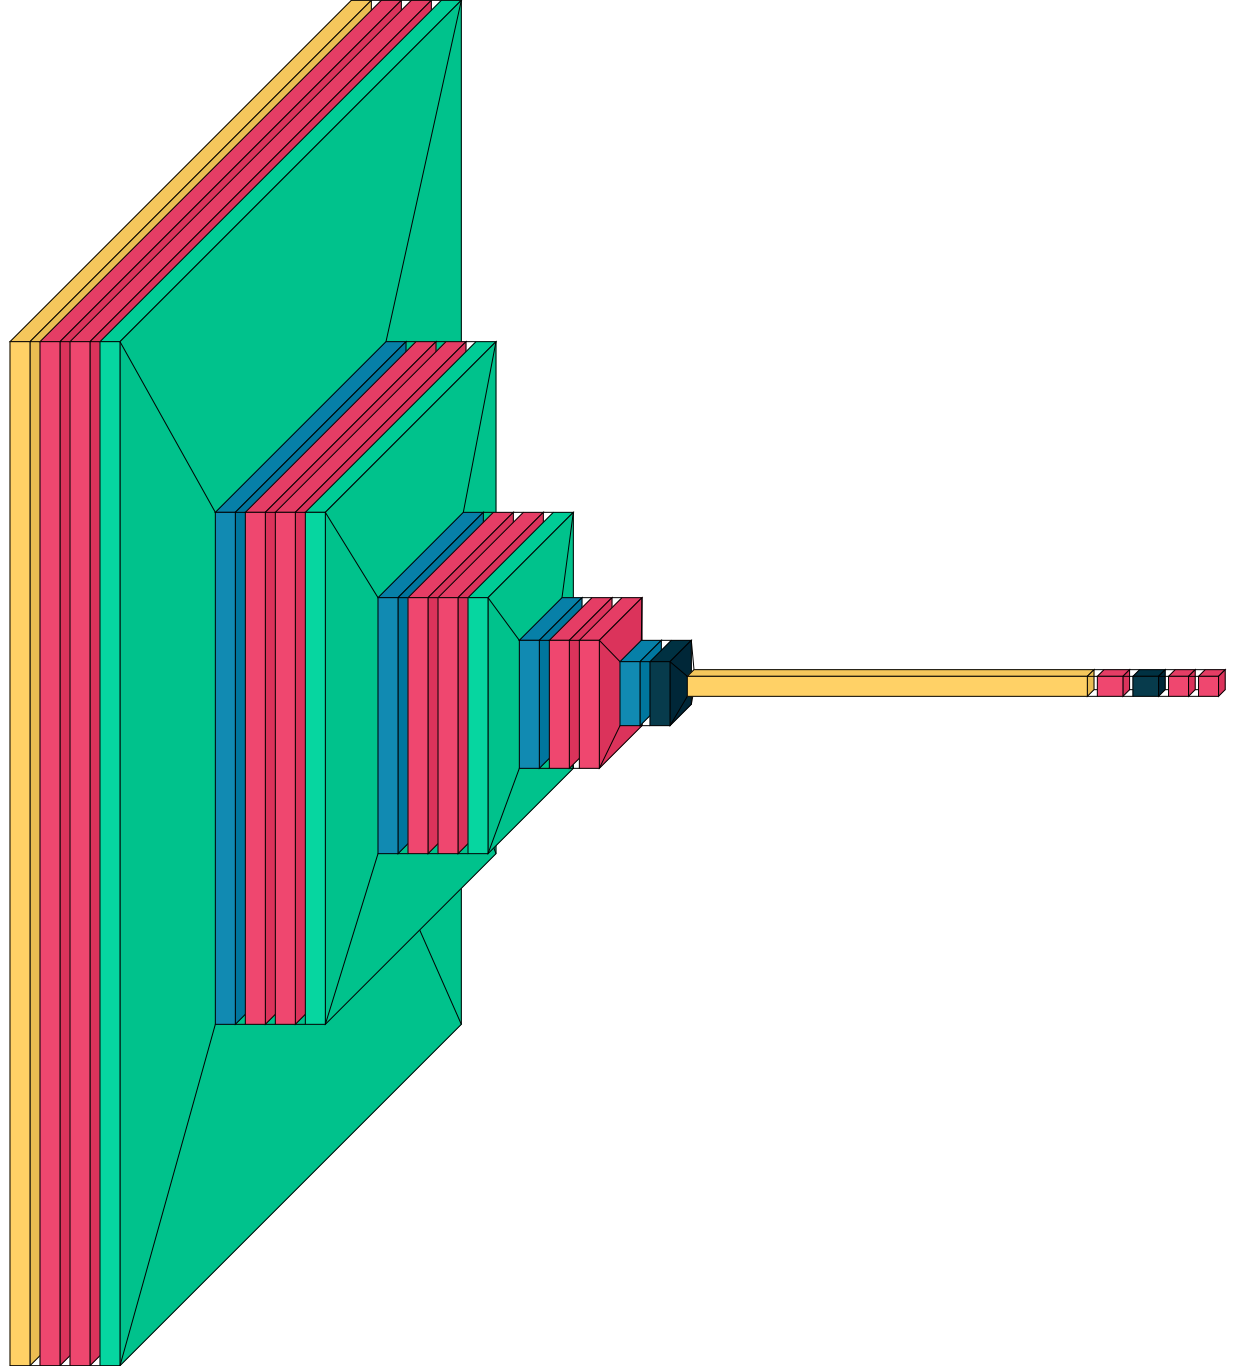

In [ ]:
# import visualkeras
# visualkeras.layered_view(best_model)
def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()
plot_confusion_matrix()

## Visualize Training Results

In [ ]:
def plot_model_results(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs_range = range(22)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.show()

### Loss model

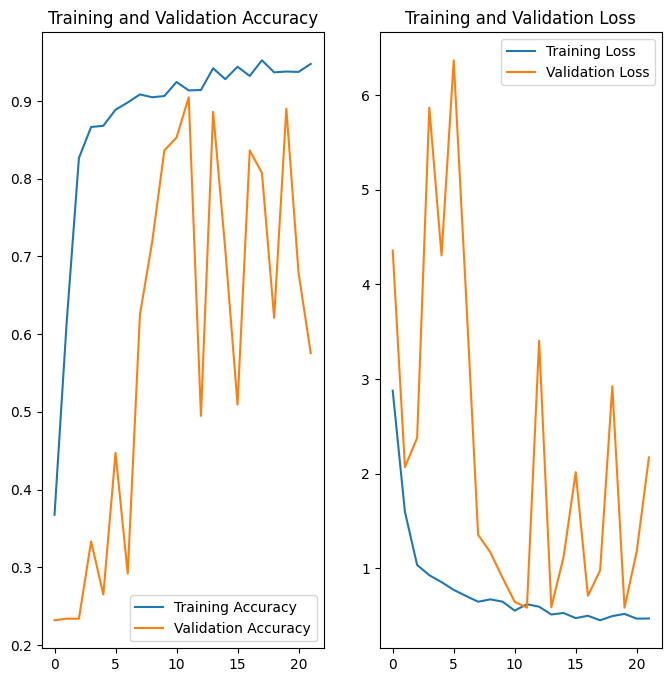

In [ ]:
plot_model_results(loss_history)

In [ ]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.Accuracy()

test = keras.utils.image_dataset_from_directory(r"{}/test".format(data_dir))

for batch in test.as_numpy_iterator():
    X, y = batch
    probabilities = best_model.predict(X)
    classes = np.argmax(probabilities, axis=-1)
    pre.update_state(y, classes)
    re.update_state(y, classes)
    acc.update_state(y, classes)

loss_model_score = best_model.evaluate(test)
print(f'Test accuracy: {loss_model_score[1]}')  # Index 1 corresponds to the accuracy metric
print(f'Test loss: {loss_model_score[0]}')
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

Found 562 files belonging to 5 classes.
18/18 [==============================] - 9s 289ms/step - loss: 0.5077 - accuracy: 0.9448
Test accuracy: 0.9448398351669312
Test loss: 0.5076504945755005
Precision: 0.9908883571624756
Recall: 0.981941282749176
Accuracy: 0.9448398351669312


### Accuracy model

In [ ]:
plot_model_results(acc_history)

NameError: ignored

In [ ]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.Accuracy()

test = keras.utils.image_dataset_from_directory(r"{}/test".format(data_dir))

for batch in test.as_numpy_iterator():
    X, y = batch
    probabilities = best_acc_model.predict(X)
    classes = np.argmax(probabilities, axis=-1)
    pre.update_state(y, classes)
    re.update_state(y, classes)
    acc.update_state(y, classes)

acc_model_score = best_acc_model.evaluate(test)
print(f'Test accuracy: {acc_model_score[1]}')  # Index 1 corresponds to the accuracy metric
print(f'Test loss: {acc_model_score[0]}')
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

Found 389 files belonging to 5 classes.
13/13 [==============================] - 1s 44ms/step - loss: 0.2092 - accuracy: 0.9177
Test accuracy: 0.9177377820014954
Test loss: 0.2092130184173584
Precision: 1.0
Recall: 0.9852398633956909
Accuracy: 0.9177377820014954


## Test

### Defining helper function

In [ ]:
def predict_image_from_path(img_path, model):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    print("Confiancas: ", score)
    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "image {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(img_path, res, percentage)
    )

    return res, percentage

### One Image

['overripe', 'raw', 'ripe', 'rotten', 'unripe']
Confiancas:  tf.Tensor([0.17494895 0.15976469 0.17005019 0.32846618 0.16677001], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/../../validation/b1_car1_pca_50.jpeg most likely belongs to rotten with a 32.85 percent confidence.
Confiancas:  tf.Tensor([0.17410348 0.15883088 0.33012128 0.16569501 0.17124929], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/../../validation/b1_car2_pca_50.jpeg most likely belongs to ripe with a 33.01 percent confidence.
Confiancas:  tf.Tensor([0.16949853 0.15626763 0.35493225 0.15994997 0.15935172], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/../../validation/b1_vic1_pca_50.jpeg most likely belongs to ripe with a 35.49 percent confidence.
Confiancas:  tf.Tensor([0.14895362 0.14895362 0.4037692  0.14895369 0.1493699 ], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TC

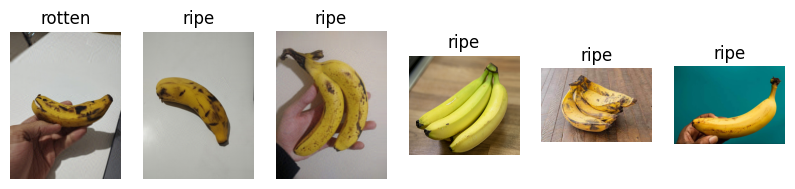

In [ ]:
print(class_names)
img_ripe = list(data_dir.glob("../../validation/*"))

ax, sub = plt.subplots(1, len(img_ripe), figsize=(10, 10))

for i in range(0, len(img_ripe)):
  res = predict_image_from_path(img_ripe[i], best_model)
  sub[i].set_title(res[0])
  sub[i].axis("off")
  # img = str(list(data_dir.glob(r"/test/{}".format(img_ripe[i]))))
  # img = img_ripe[]
  sub[i].imshow(cv.cvtColor(cv.imread(str(img_ripe[i])), cv.COLOR_BGR2RGB))

# res = predict_image_from_path(img_ripe, best_model)
# # res = predict_image_from_path(img_ripe, best_acc_model)

# plt.imshow(cv.cvtColor(cv.imread(img_ripe), cv.COLOR_BGR2RGB))
# plt.title(res[0])
# plt.axis("off")

In [ ]:
data_dir.glob("test/*.jpeg")

<generator object Path.glob at 0x7e22899b31b0>

## Ploting feature map

In [ ]:
# model = best_loss_model
model = best_model
for i in range(len(model.layers)):
 layer = model.layers[i]
 # check for convolutional layer
 if 'conv' not in layer.name:
  continue
 # summarize output shape
 print(i, layer.name, layer.output.shape)

1 conv2d (None, 256, 256, 32)
2 conv2d_1 (None, 256, 256, 32)
5 conv2d_2 (None, 128, 128, 64)
6 conv2d_3 (None, 128, 128, 64)
9 conv2d_4 (None, 64, 64, 128)
10 conv2d_5 (None, 64, 64, 128)
13 conv2d_6 (None, 32, 32, 128)
14 conv2d_7 (None, 32, 32, 128)


1/1 [==============================] - 0s 267ms/step


<ipython-input-24-923fd4ef9c17>:38: RuntimeWarning: invalid value encountered in divide
  feature_image/= feature_image.std ()


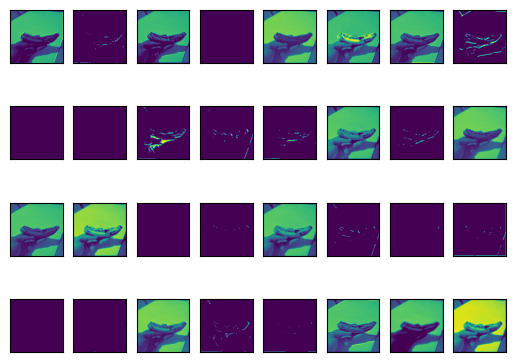

In [ ]:
from pyparsing.helpers import lineStart
from keras import Model
from numpy import expand_dims

# Creating model that ouputs featuer map
feat_map_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

# loading the image
img_path = list(data_dir.glob("../../validation/*.jpeg"))[0]
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
# print(img_array.max(), img_array.min())
# print(img_array.max(), img_array.min())
img_array = tf.expand_dims(img_array, 0)
img_array = img_array / 255.0

# getting feature maps
feature_maps = feat_map_model.predict(img_array)
# print(feature_maps.shape)
square = 8
lines = 4
ix = 1
for _ in range(lines):
 for _ in range(square):
  # specify subplot and turn of axis
  ax = plt.subplot(lines, square, ix)
  ax.set_xticks([])
  ax.set_yticks([])

  # plot filter channel in grayscale
  # plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')

  # plot the images
  feature_map = feature_maps[0, :, :, ix - 1]
  size = feature_map.shape[1]
  feature_image = feature_map
  feature_image-= feature_image.mean()
  feature_image/= feature_image.std ()
  feature_image*=  64
  feature_image+= 128
  feature_image= np.clip(feature_maps[0], 0, 255).astype('uint8')
  # image_belt[:, i * size : (i + 1) * size] = feature_image
  plt.imshow(feature_image[:, :, ix-1])
  ix += 1
# show the figure
plt.show()

In [ ]:
# plt.plot(model.layers[2].get_weights())
model.layers[1].get_weights()

### One directory of images

In [ ]:
wrong_class = {
  # 'apple': [],
  # 'orange': [],
  # 'banana': [],
  'overripe': [],
  'raw': [],
  'ripe': [],
  'rotten': [],
  'unripe': []
}
def test_by_class(label):
  imgs = list(data_dir.glob(f"test/{label}/*.jpg"))

  total_size = len(imgs)
  total_right = 0

  for img_path in imgs:
      res, percentage = predict_image_from_path(img_path, best_model)

      if res == label:
          total_right += 1
      else:
        wrong_class[label].append((img_path, res))

  print(
      f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
  )

### Fruits

In [ ]:
test_by_class('banana')

Confiancas:  tf.Tensor([0.21199898 0.576044   0.21195696], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/banana/img_0000.jpg most likely belongs to banana with a 57.60 percent confidence.
Confiancas:  tf.Tensor([0.22344144 0.5613348  0.21522379], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/banana/img_0014.jpg most likely belongs to banana with a 56.13 percent confidence.
Confiancas:  tf.Tensor([0.21195635 0.5760981  0.21194564], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/banana/img_0001.jpg most likely belongs to banana with a 57.61 percent confidence.
Confiancas:  tf.Tensor([0.2120887  0.5759221  0.21198916], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/banana/img_0017.jpg most likely belongs to banana with a 57.59 percent confidence.
Confiancas:  tf.Tensor([0.21266069 0.5751363  0.212203  ], shape=(3,), dtype=float32)
image /content/drive/MyDri

In [ ]:
test_by_class('apple')

Confiancas:  tf.Tensor([0.38461667 0.38055032 0.23483302], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/apple/img_0014.jpg most likely belongs to apple with a 38.46 percent confidence.
Confiancas:  tf.Tensor([0.56222355 0.21546923 0.2223072 ], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/apple/img_0001.jpg most likely belongs to apple with a 56.22 percent confidence.
Confiancas:  tf.Tensor([0.5684112  0.2179484  0.21364045], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/apple/img_0000.jpg most likely belongs to apple with a 56.84 percent confidence.
Confiancas:  tf.Tensor([0.5687125  0.21748212 0.21380538], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/apple/img_0002.jpg most likely belongs to apple with a 56.87 percent confidence.
Confiancas:  tf.Tensor([0.5758324  0.21200271 0.2121648 ], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptec

In [ ]:
test_by_class('orange')

Confiancas:  tf.Tensor([0.2142065  0.21301271 0.5727808 ], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/orange/img_0028.jpg most likely belongs to orange with a 57.28 percent confidence.
Confiancas:  tf.Tensor([0.21434437 0.2125958  0.57305986], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/orange/img_0003.jpg most likely belongs to orange with a 57.31 percent confidence.
Confiancas:  tf.Tensor([0.21397288 0.21248832 0.5735388 ], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/orange/img_0015.jpg most likely belongs to orange with a 57.35 percent confidence.
Confiancas:  tf.Tensor([0.21232796 0.21205221 0.5756198 ], shape=(3,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/dataset/test/orange/img_0001.jpg most likely belongs to orange with a 57.56 percent confidence.
Confiancas:  tf.Tensor([0.23678786 0.24652444 0.5166877 ], shape=(3,), dtype=float32)
image /content/drive/MyDri

### Banana stages

#### RAW

In [ ]:
test_by_class("raw")

Confiancas:  tf.Tensor([0.14894783 0.4038149  0.14894785 0.14894785 0.14934146], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/raw/bra_0370.jpg most likely belongs to raw with a 40.38 percent confidence.
Confiancas:  tf.Tensor([0.14906754 0.4028738  0.1490745  0.14907543 0.14990868], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/raw/bra_0165.jpg most likely belongs to raw with a 40.29 percent confidence.
Confiancas:  tf.Tensor([0.14891091 0.4041081  0.14891092 0.14891091 0.14915915], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/raw/bra_0162.jpg most likely belongs to raw with a 40.41 percent confidence.
Confiancas:  tf.Tensor([0.15169021 0.380651   0.15172358 0.15169343 0.1642417 ], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/raw/bra_0176.jpg most likely belongs to raw with a 38.07 percent conf

#### UNRIPE

In [ ]:
test_by_class("unripe")

Confiancas:  tf.Tensor([0.14888582 0.14903377 0.14888719 0.14888611 0.40430713], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/unripe/IMG0715.jpg most likely belongs to unripe with a 40.43 percent confidence.
Confiancas:  tf.Tensor([0.14919686 0.14989464 0.14979127 0.14926864 0.40184855], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/unripe/IMG0649.jpg most likely belongs to unripe with a 40.18 percent confidence.
Confiancas:  tf.Tensor([0.14889775 0.14908987 0.14890134 0.14889847 0.4042126 ], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/unripe/IMG0438.jpg most likely belongs to unripe with a 40.42 percent confidence.
Confiancas:  tf.Tensor([0.1490977  0.15000784 0.14914691 0.14912148 0.40262607], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/unripe/IMG0541.jpg most likely belongs to unripe with 

#### RIPE

In [ ]:
test_by_class("ripe")

Confiancas:  tf.Tensor([0.15012641 0.15012656 0.3942106  0.15013312 0.15540333], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/ripe/IMG1790.jpg most likely belongs to ripe with a 39.42 percent confidence.
Confiancas:  tf.Tensor([0.3563262  0.15449157 0.16396932 0.17055447 0.1546584 ], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/ripe/IMG1269.jpg most likely belongs to overripe with a 35.63 percent confidence.
Confiancas:  tf.Tensor([0.14895944 0.14895964 0.4037273  0.1489737  0.14937995], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/ripe/IMG0816.jpg most likely belongs to ripe with a 40.37 percent confidence.
Confiancas:  tf.Tensor([0.1492014  0.1492014  0.40179032 0.14920217 0.15060467], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/ripe/IMG1889.jpg most likely belongs to ripe with a 40.18 perc

#### OVERRIPE

In [ ]:
test_by_class("overripe")

Confiancas:  tf.Tensor([0.38799855 0.15101382 0.1568065  0.15323032 0.15095076], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/overripe/IMG1574.jpg most likely belongs to overripe with a 38.80 percent confidence.
Confiancas:  tf.Tensor([0.40303463 0.14905006 0.14930482 0.14956181 0.14904875], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/overripe/IMG1394.jpg most likely belongs to overripe with a 40.30 percent confidence.
Confiancas:  tf.Tensor([0.40437612 0.14887734 0.14895141 0.14891802 0.14887717], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/overripe/IMG1901.jpg most likely belongs to overripe with a 40.44 percent confidence.
Confiancas:  tf.Tensor([0.40233463 0.1491406  0.14956836 0.14982021 0.14913614], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/overripe/IMG1130.jpg most likely belongs t

#### ROTTEN

In [ ]:
test_by_class("rotten")

Confiancas:  tf.Tensor([0.14896202 0.14888415 0.14893866 0.40432638 0.14888881], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/rotten/IMG0409.jpg most likely belongs to rotten with a 40.43 percent confidence.
Confiancas:  tf.Tensor([0.15039408 0.14986657 0.15202856 0.39753115 0.15017961], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/rotten/IMG0250.jpg most likely belongs to rotten with a 39.75 percent confidence.
Confiancas:  tf.Tensor([0.1489208  0.14889807 0.1490333  0.4042241  0.14892381], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/rotten/IMG0386.jpg most likely belongs to rotten with a 40.42 percent confidence.
Confiancas:  tf.Tensor([0.15828064 0.155639   0.16990733 0.356505   0.15966797], shape=(5,), dtype=float32)
image /content/drive/MyDrive/sptech/TCC/fruits_dataset/banana/test/rotten/IMG0273.jpg most likely belongs to rotten with 

#### Apple

In [ ]:
test_by_class("apple")

Confiancas:  tf.Tensor(
[0.31179008 0.114702   0.11470158 0.11470158 0.11470158 0.11470158
 0.11470158], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/apple/a_0001.jpg most likely belongs to apple with a 31.18 percent confidence.
Confiancas:  tf.Tensor(
[0.3117905  0.11470155 0.11470155 0.11470155 0.11470155 0.11470178
 0.11470155], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/apple/a_0003.jpg most likely belongs to apple with a 31.18 percent confidence.
Confiancas:  tf.Tensor(
[0.28351542 0.11754952 0.13077019 0.11704104 0.11704134 0.11704149
 0.11704105], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/apple/a_0002.jpg most likely belongs to apple with a 28.35 percent confidence.
Confiancas:  tf.Tensor(
[0.31178972 0.11470222 0.11470163 0.11470163 0.11470163 0.11470164
 0.11470163], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/apple/a_0005.jpg most l

#### Orange

In [ ]:
test_by_class("orange")

Confiancas:  tf.Tensor(
[0.11483557 0.3115465  0.11472367 0.11472356 0.11472356 0.11472356
 0.11472356], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/orange/o_001.jpg most likely belongs to orange with a 31.15 percent confidence.
Confiancas:  tf.Tensor(
[0.12593216 0.29221007 0.11639183 0.11636556 0.11636915 0.11636556
 0.1163656 ], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/orange/o_002.jpg most likely belongs to orange with a 29.22 percent confidence.
Confiancas:  tf.Tensor(
[0.11481327 0.3115872  0.11471998 0.1147199  0.1147199  0.1147199
 0.1147199 ], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/orange/o_003.jpg most likely belongs to orange with a 31.16 percent confidence.
Confiancas:  tf.Tensor(
[0.11576292 0.3098516  0.11488264 0.11487582 0.11487573 0.11487566
 0.1148757 ], shape=(7,), dtype=float32)
image /content/drive/MyDrive/TCC/fruits_dataset/test/orange/o_004.jpg most

## Looking for wrong classifications

In [ ]:
def show_wrong_classification(label):
  imgs = wrong_class[label]
  total = len(imgs)
  print(len(imgs))

  if total == 1:
    (img_path, res) = imgs[0]
    img = tf.keras.utils.load_img(
      img_path, target_size=(img_height, img_width)
    )
    plt.title(res)
    plt.imshow(img)
    return

  if len(imgs) > 0:
    rows = 1
    cols = 1

    # Getting perfect quantity of rows and columns
    divs = [i for i in range(1, (total + 1)) if total % i == 0]
    if len(divs) == 1:
      rows = 1
      cols = 1
    elif len(divs) <= 2:
      rows = divs[0]
      cols = divs[1]
    elif len(divs) % 2 == 0:
      half = int(len(divs) / 2)
      rows = divs[half - 1]
      cols = divs[half]
    else:
      half = int(len(divs) / 2)
      rows = divs[half]
      cols = divs[half]

    if (cols == 23):
      rows = 4
      cols = 6
    print('Rows and cols: ', rows, cols)
    n = 0
    ax, sub = plt.subplots(rows, cols, figsize=(8, 8))
    for i in range(rows):
      for j in range(cols):
        # print(n)
        if n == len(imgs):
          break

        (img_path, res) = imgs[n]
        img = tf.keras.utils.load_img(
          img_path, target_size=(img_height, img_width)
        )
        if rows == 1:
          sub[n].set_title(res)
          sub[n].axis("off")
          sub[n].imshow(img)
        else:
          sub[i, j].set_title(res)
          sub[i, j].axis("off")
          sub[i, j].imshow(img)
        n += 1

  plt.show()

1


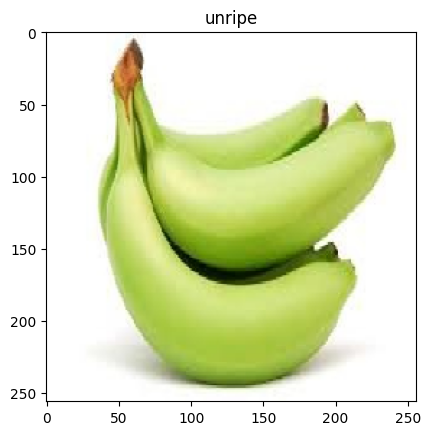

In [ ]:
show_wrong_classification('raw')

14
Rows and cols:  2 7


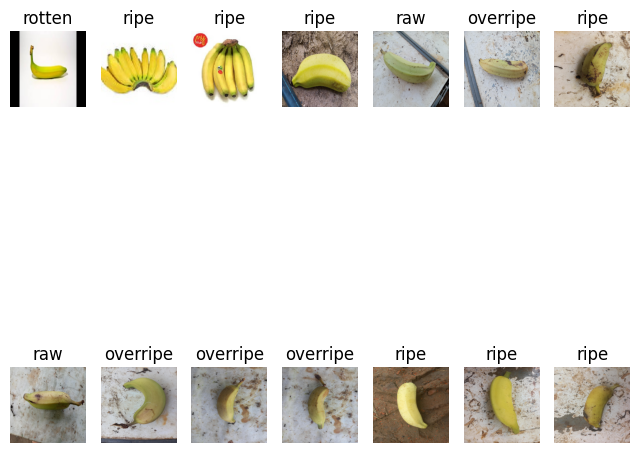

In [ ]:
show_wrong_classification('unripe')

16
Rows and cols:  4 4


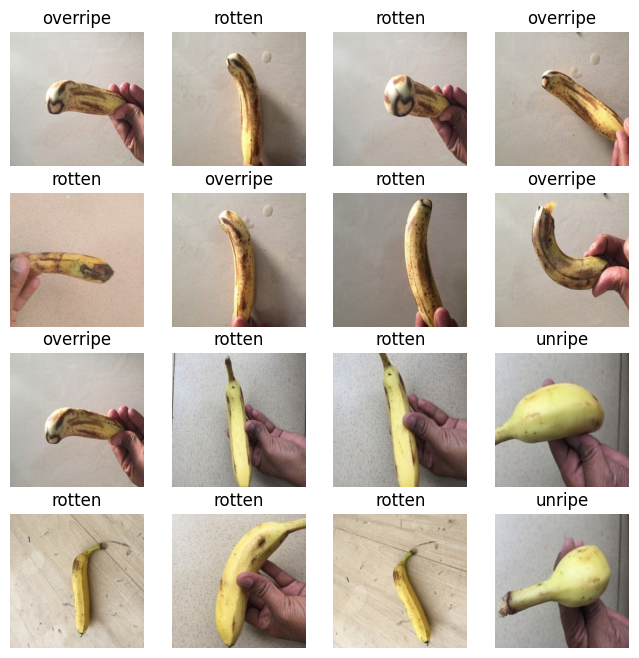

In [ ]:
show_wrong_classification('ripe')

4
Rows and cols:  2 2


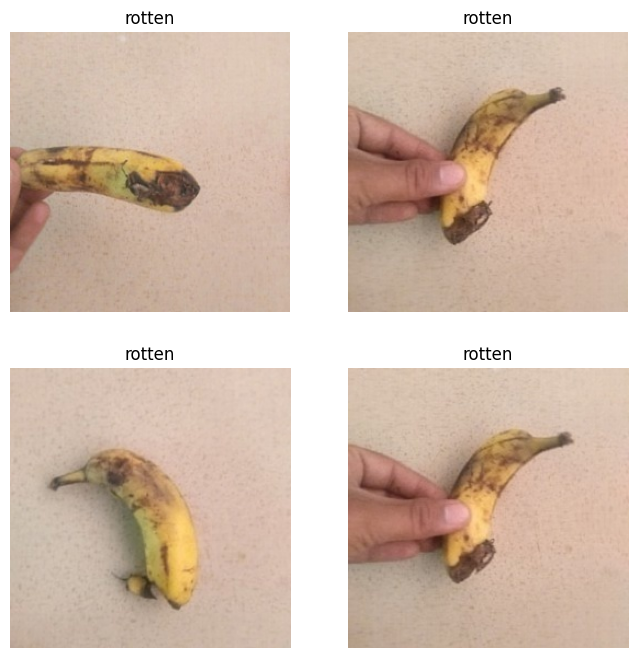

In [ ]:
show_wrong_classification('overripe')

1


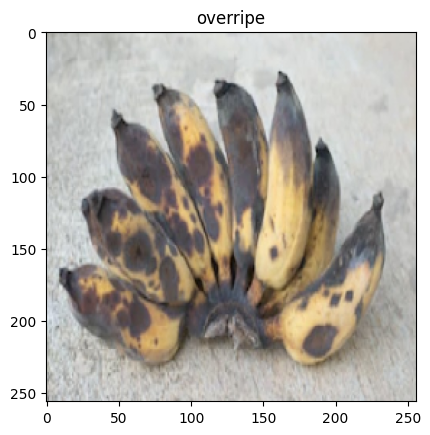

In [ ]:
show_wrong_classification('rotten')

### Testing with images taken by me

In [ ]:
raw_right = 0
ripe_right = 0
overripe_right = 0

imgs_taken_by_me_path = "/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/taken_by_me/dataset_pca/"

for img_class in os.listdir(imgs_taken_by_me_path):
    for img in os.listdir(os.path.join(imgs_taken_by_me_path, img_class)):
        img_path = os.path.join(imgs_taken_by_me_path, img_class, img)
        # print(img_path)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "raw" and res == "raw":
            raw_right += 1
        elif img_class == "ripe" and res == "ripe":
            overripe_right += 1
        elif img_class == "overripe" and res == "overripe":
            ripe_right += 1
    print()

raw_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "raw")))
overripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "ripe")))
ripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "overripe")))
total_size = raw_size + overripe_size + ripe_size
total_right = raw_right + overripe_right + ripe_right

print(
    f"Result raw: got { raw_right }/{ raw_size } right, which means { round(raw_right * 100 / raw_size, 2) }%"
)
print(
    f"Result overripe: got { overripe_right }/{ overripe_size } right, which means { round(overripe_right * 100 / overripe_size, 2) }%"
)
print(
    f"Result ripe: got { ripe_right }/{ ripe_size } right, which means { round(ripe_right * 100 / ripe_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to overripe with a 99.70 percent confidence.
This image most likely belongs to ripe with a 99.76 percent confidence.
This image most likely belongs to overripe with a 68.22 percent confidence.
This image most likely belongs to ripe with a 99.75 percent confidence.
This image most likely belongs to overripe with a 90.43 percent confidence.

This image most likely belongs to raw with a 72.64 percent confidence.
This image most likely belongs to raw with a 60.23 percent confidence.
This image most likely belongs to ripe with a 76.72 percent confidence.
This image most likely belongs to ripe with a 64.29 percent confidence.
This image most likely belongs to ripe with a 81.26 percent confidence.

This image most likely belongs to ripe with a 83.28 percent confidence.
This image most likely belongs to ripe with a 99.99 percent confidence.
This image most likely belongs to ripe with a 99.95 percent confidence.
This image most likely belongs to overripe with a 91

## Save

In [ ]:
model.save('models/banana_stages_classifier.h5')


In [ ]:
loaded_model = tf.keras.models.load_model('models/banana_stages_classifier.h5')

In [ ]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       